# Task 1: Extend the results on the titanic dataset in the module of machine learning in Python, by using the additional features that are created and considered in the practice 7.

In the practice 7, we considered the new categorical variable for the fare as below.

labels = ["£0", "£1–£25", "£26–£50", "£51–£75", "£76–£100", "£101–£125", "£126–£150", "> £150"]

Moreover, we considered and added family size as below.

data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

Here, the values in SibSp column show the number of siblings and/or spouses a passenger had on titanic; the values in Parch column show the number of parents and/or children a passenger had on titanic. So we need to add them up (with +1 for the passenger himself/herself) for each ticket class.

So, we use those variables in our analysis below.


In [1]:
# initial set up

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml  #using openml to import data
from sklearn.metrics import RocCurveDisplay # from sklearn.metrics import plot_roc_curve # plot_roc_curve has been removed from sklearn.metrics since scikit-learn 1.2.
from sklearn.model_selection import train_test_split, GridSearchCV      
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer #transform different types

For the Titanic dataset on OpenML (ID 40945), the target is set as "survived". 
Thus,
- X_initial contains all the features except the target (survived);
- y contains the target/response (survived).

In [2]:
X_initial, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

# Pre-Processing 

Let's first add fare_bin and family_size to the data.
Then, we create the data_transformer pipeline.

In [3]:
breaks = [0, 0.01, 25, 50, 75, 100, 125, 150, float('inf')]
labels = ["£0", "£1–£25", "£26–£50", "£51–£75", "£76–£100", "£101–£125", "£126–£150", "> £150"]
fare_bin = pd.cut(X_initial['fare'], bins=breaks, labels=labels, right=False, include_lowest=True)
X_initial['fare_bin'] = fare_bin
X_initial.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,fare_bin
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",> £150
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",> £150
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",> £150
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",> £150
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",> £150


In [4]:
X_initial['family_size'] = X_initial['sibsp'] + X_initial['parch'] + 1
X_initial.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,fare_bin,family_size
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",> £150,1
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",> £150,4
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",> £150,4
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",> £150,4
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",> £150,4


In [5]:
# combine the two datasets
combine_dataset = pd.concat([X_initial, y], axis=1)
combine_dataset.head()

# features from the dataset
features = ['age', 'fare','family_size','embarked','sex','pclass','fare_bin']
X = X_initial[features].copy()

In [6]:
numerical_features = ['age', 'fare', 'family_size']

# Applying SimpleImputer and StandardScaler into a pipelin
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())])

In [7]:
categorical_features = ['embarked', 'sex', 'pclass','fare_bin']

# Applying SimpleImputer and then OneHotEncoder into another pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [8]:
data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)]) 

In [9]:
data_transformer 

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'fare', 'family_size']),
                                ('categorical',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['embarked', 'sex', 'pclass', 'fare_bin'])])

# Pipelines With Logistic Regression

In [10]:
pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression(max_iter=10000))])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_initial, y, test_size=0.5,random_state=1)

In [12]:
param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean', 'median'],
    'data_transformer__categorical__imputer__strategy': ['constant','most_frequent']
}
grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)
grid_lr.fit(X_train, y_train);

# Pipelines With Gradient Boosting

In [13]:
pipe_gdb = Pipeline(steps=[('data_transformer', data_transformer),
       ('pipe_gdb',GradientBoostingClassifier(random_state=2))])

grid_gdb = GridSearchCV(pipe_gdb, param_grid=param_grid)
grid_gdb.fit(X_train, y_train);

# Compare the regression results

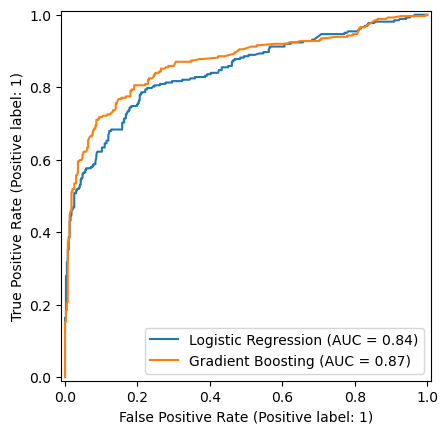

In [14]:
ax = plt.gca()
RocCurveDisplay.from_estimator(grid_lr, X_test, y_test, ax=ax, name='Logistic Regression')
RocCurveDisplay.from_estimator(grid_gdb, X_test, y_test, ax=ax, name='Gradient Boosting')
plt.show()

# Task 2: Extend the results further by using other valid classification models listed in the notes on machine learning frameworks. Please try as many as you can.

We used Logistic regression and Gradient boosting and observed their AUC is respectively 0.84 and 0.87.

We run these models and check their AUC.
- Classification tree
- Random forests
- Gaussian process classification
- Support vector machines

## Classification Tree

In [15]:

from sklearn.tree import DecisionTreeClassifier

pipe_tree = Pipeline([
    ('data_transformer', data_transformer),
    ('tree', DecisionTreeClassifier(random_state=2))
])
grid_tree = GridSearchCV(pipe_tree, param_grid=param_grid)  # define param_grid accordingly
grid_tree.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('data_transformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'fare',
                                                                          'family_size']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['embarked',
                                                                          'sex',
                                                                          'pclass',
                                                                          'fare_bin'])])),
                                       ('tree',
                                        DecisionTreeClassifier(random_state=2))]),
             param_grid={'data_transformer__categorical__imputer__strategy': ['constant',
                                                                              'most_frequent'],
                         'data_transformer__numerical__imputer__strategy': ['mean',
                                                                            'median']})

## Random Forests Classification

In [16]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline([
    ('data_transformer', data_transformer),
    ('rf', RandomForestClassifier(random_state=2))
])
grid_rf = GridSearchCV(pipe_rf, param_grid=param_grid)  # define param_grid accordingly
grid_rf.fit(X_train, y_train)


GridSearchCV(estimator=Pipeline(steps=[('data_transformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'fare',
                                                                          'family_size']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['embarked',
                                                                          'sex',
                                                                          'pclass',
                                                                          'fare_bin'])])),
                                       ('rf',
                                        RandomForestClassifier(random_state=2))]),
             param_grid={'data_transformer__categorical__imputer__strategy': ['constant',
                                                                              'most_frequent'],
                         'data_transformer__numerical__imputer__strategy': ['mean',
                                                                            'median']})

## Deep or Shallow Neural Networks

##  Gaussian Process Classification

In [17]:
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor

pipe_gp_clf = Pipeline([
    ('data_transformer', data_transformer),
    ('gp', GaussianProcessClassifier(random_state=2))
])
grid_gp_clf = GridSearchCV(pipe_gp_clf, param_grid=param_grid)
grid_gp_clf.fit(X_train, y_train)


GridSearchCV(estimator=Pipeline(steps=[('data_transformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'fare',
                                                                          'family_size']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['embarked',
                                                                          'sex',
                                                                          'pclass',
                                                                          'fare_bin'])])),
                                       ('gp',
                                        GaussianProcessClassifier(random_state=2))]),
             param_grid={'data_transformer__categorical__imputer__strategy': ['constant',
                                                                              'most_frequent'],
                         'data_transformer__numerical__imputer__strategy': ['mean',
                                                                            'median']})

## Support Vector Machines

In [18]:
from sklearn.svm import SVC, SVR

pipe_svm = Pipeline([
    ('data_transformer', data_transformer),
    ('svm', SVC(probability=True, random_state=2))
])
grid_svm = GridSearchCV(pipe_svm, param_grid=param_grid)
grid_svm.fit(X_train, y_train)



GridSearchCV(estimator=Pipeline(steps=[('data_transformer',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'fare',
                                                                          'family_size']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['embarked',
                                                                          'sex',
                                                                          'pclass',
                                                                          'fare_bin'])])),
                                       ('svm',
                                        SVC(probability=True,
                                            random_state=2))]),
             param_grid={'data_transformer__categorical__imputer__strategy': ['constant',
                                                                              'most_frequent'],
                         'data_transformer__numerical__imputer__strategy': ['mean',
                                                                            'median']})

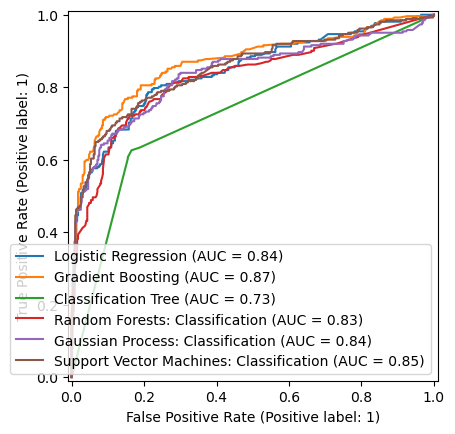

In [19]:
ax = plt.gca()
RocCurveDisplay.from_estimator(grid_lr, X_test, y_test, ax=ax, name='Logistic Regression')
RocCurveDisplay.from_estimator(grid_gdb, X_test, y_test, ax=ax, name='Gradient Boosting')
RocCurveDisplay.from_estimator(grid_tree, X_test, y_test, ax=ax, name='Classification Tree')
RocCurveDisplay.from_estimator(grid_rf, X_test, y_test, ax=ax, name='Random Forests: Classification')
RocCurveDisplay.from_estimator(grid_gp_clf, X_test, y_test, ax=ax, name='Gaussian Process: Classification')
RocCurveDisplay.from_estimator(grid_svm, X_test, y_test, ax=ax, name='Support Vector Machines: Classification')
plt.show()